# Deep Learning With Tensorflow and MNIST

by [Danny Breyfogle](https://github.com/dbreyfogle)

---

This notebook primarily serves as an independent study of the popular open-source machine learning library, Tensorflow. Using the MNIST dataset of handwritten digits, I will explore deep neural networks along with visualization tools including Tensorflow's Tensorboard. Explanations of learned concepts and tools will be documented in hopes to help others learning Tensorflow, while also proving any progress I might make in machine learning.

Tensorflow may be downloaded at [www.tensorflow.org](https://www.tensorflow.org).

## Table of Contents

1. [The Data](#data)  
    1.1. [Labelings](#labels)  
    1.2. [Visualization](#visual)  
2. [Introducing Tensorflow](#introducing)  
    2.1. [Placeholders](#placehold)  
    2.2. [Variables](#variables)  
3. [A Simple Neural Network](#simple)  
    3.1. [Loss and Optimizers](#loss)  
    3.2. [Training the Network](#training)  
    3.3. [Calculating Accuracy](#accuracy)  
    3.4. [Visualizing Errors](#errors)  
4. [Deep Neural Networks](#deep)  
    4.1. [Constructing Multiple Layers](#constructing)  
    4.2. [The Errors](#errors2)  
5. [Tensorboard](#tensorboard)  
    5.1. [Graph Visualizer](#graph)  
    5.2. [Summaries](#summaries)  
6. [Convolutional Neural Networks](#convolutional)  
    6.1. [Decaying Learning Rate](#learning)  
    6.2. [Dropout Regularization](#dropout)  
    6.3. [Errors and Logs](#logs)  
---

## The Data<a id='data'></a>

First import any useful libraries including `tensorflow`.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
import math
from IPython.display import Image

The MNIST dataset is conveniently included with Tensorflow and can be read in and cleaned with a single line of code.

In [2]:
mnist = read_data_sets('data',one_hot=True,reshape=False,validation_size=0)

print('\nTraining set size: {}'.format(mnist.train.num_examples))
print('Test set size: {}'.format(mnist.test.num_examples))

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/t10k-labels-idx1-ubyte.gz

Training set size: 60000
Test set size: 10000


### Labelings<a id='labels'></a>

Below you can see the one-hot encodings for the first 10 images in the training set:

In [3]:
mnist.train.labels[0:10]

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

By observing where the ones occur, you can guess that the first image is a 5, the second is a 0, third is a 4, and so on. It may be useful to create a function which returns classes given labels.

In [4]:
def clss(labels):
    return np.array([label.argmax() for label in labels])

clss(mnist.train.labels[0:11])

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3])

### Visualization<a id='visual'></a>

Each handwritten digit was originally captured as a 28x28 pixel grayscale image, but has been converted to a 28x28 array with values ranging from 0 to 1. We can define a function to help with visualization.

In [5]:
def view_images(indices=range(0,18),train=True,shuffle=True):
    fig, axes = plt.subplots(3,6,figsize=(12,6)) # Dimensions
    fig.subplots_adjust(hspace=0.3,wspace=0.6)
    
    if train:
        if shuffle:
            n = mnist.train.num_examples
            indices = np.random.choice(n,18,replace=False) # Randomly choose from n images
        images = mnist.train.images[indices]
        classes = clss(mnist.train.labels[indices])
        
    else:
        if shuffle:
            n = mnist.test.num_examples
            indices = np.random.choice(n,18,replace=False)
        images = mnist.test.images[indices]
        classes = clss(mnist.test.labels[indices])
        
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(28,28),cmap='binary') # 28x28 grayscale
        xlabel = 'Class: {}'.format(classes[i])
        ax.set_xlabel(xlabel) # Add label
        ax.set_xticks([]) # Remove ticks
        ax.set_yticks([])

Now we can view the images to make sure everything checks out.

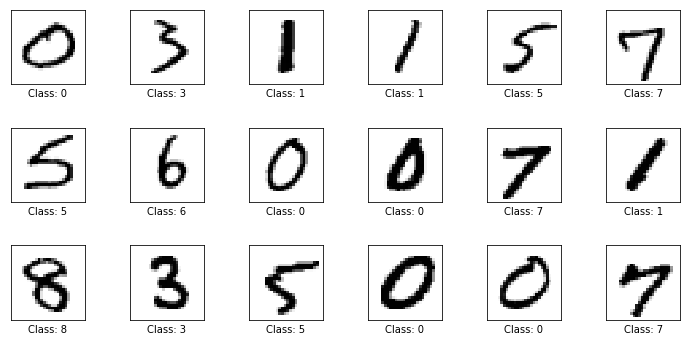

In [6]:
view_images(train=True,shuffle=True)

---
## Introducing Tensorflow<a id='introducing'></a>

It's important to understand that Tensorflow does not compute line by line like you might expect when working with Python. Most Tensorflow code is actually used to define a computational graph in memory which is then run later on.

In [7]:
a = tf.constant(2,dtype=tf.int32)
b = tf.constant(3,dtype=tf.int32)

print(a + b)

Tensor("add:0", shape=(), dtype=int32)


Here you don't get 5 back like you might expect. Instead you get information describing the structure of the object. To actually compute values in Tensorflow, you need to open a session.

In [8]:
sess = tf.InteractiveSession() # Open session

result = sess.run(a + b)
print('a + b = {}'.format(result))

a + b = 5


### Placeholders<a id='placehold'></a>

Placeholders in Tensorflow are a sort of contract that you make when defining your computational structure. Tensorflow expects you to input these values when you run your calculation. This is done using `feed_dict`.

In [9]:
c = tf.placeholder(tf.float32,shape=[2,1])
d = tf.placeholder(tf.float32,shape=[1,2])

print(sess.run(tf.matmul(c,d),feed_dict={c:[[1],[2]],d:[[3,4]]}))

[[ 3.  4.]
 [ 6.  8.]]


Notice how you can add shape to describe multidimensional information.

### Variables<a id='variables'></a>

Tensorflow variables are trainable parameters. These are values that Tensorflow will modify as your model trains. Weights and biases in a neural network, for example, are commonly used variables in Tensorflow.

In [10]:
x = tf.placeholder(tf.float32)
w = tf.Variable([1.0],tf.float32)
b = tf.Variable([3.0],tf.float32)

linear_model = w*x + b

sess = tf.InteractiveSession() # Open session
tf.global_variables_initializer().run() # Initialize variables

print(sess.run(linear_model,feed_dict={x:[1,2,3]}))

[ 4.  5.  6.]


---
## A Simple Neural Network<a id='simple'></a>

With some of the basics down, we can begin to define a simple neural network.

In [11]:
x = tf.placeholder(tf.float32,shape=[None,28,28,1]) # Images
xx = tf.reshape(x,[-1,28*28]) # Flatten

w = tf.Variable(tf.ones([28*28,10])) # Ones initially
b = tf.Variable(tf.zeros([10])) # Zeros initially

logits = tf.matmul(xx,w) + b
y = tf.nn.softmax(logits) # Apply softmax

Here, `x` is a collection of our MNIST images. `None` means that this dimension can be any length. This allows us batch images together.

Since we are implementing a fully connected layer, we must flatten or reshape the image into a 1-D vector before multiplying our weights and adding biases.

Our weights and biases are `tf.Variables` since they will be modified during computation. Weights are initialized as ones, and biases as zeros. Since there are 10 classes of digits, we will be outputting to 10 channels.

We can conveniently take a softmax activation using `tf.nn.softmax`.

Keep in mind that we haven't actually computed any values here. This code simply defines the structure of our graph.

### Loss and Optimizers<a id='loss'></a>

In order to train the model we need to define our loss and optimization. Tensorflow includes many useful methods to make this an easy process. Here we will use cross entropy and gradient decent.

In [12]:
y_ = tf.placeholder(tf.float32,[None,10]) # Labels

xent = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=logits)
xent = tf.reduce_mean(xent)*100 # Multiply by 100 since batching

train_step = tf.train.GradientDescentOptimizer(0.01).minimize(xent) # To run during training

We will be batching images in sets of 100, so we apply `reduce_mean` and multiply by 100 in order to calculate the total cross entropy of the batch.

During training, we will loop through `train_step` which calculates the gradients and modifies our weights and biases accordingly. The learning rate is 0.01.

### Training the Network<a id='training'></a>

We now have everything we need to train our network. We will train for one epoch, i.e. 600 batches.

In [13]:
sess = tf.InteractiveSession() # Open session
tf.global_variables_initializer().run() # Initialize variables

# Training parameters
iterations = 600
batch_size = 100
notify_every = 100

for i in range(1,iterations + 1):
    batch_x, batch_y = mnist.train.next_batch(batch_size) # Get next batch from train
    sess.run(train_step,feed_dict={x:batch_x,y_:batch_y}) # Train network on batch
    
    if i % notify_every==0:
        print('On batch {}...'.format(i)) # View progress
    if i % iterations==0:
        print('Done!')

On batch 100...
On batch 200...
On batch 300...
On batch 400...
On batch 500...
On batch 600...
Done!


Great! We have trained a simple neural network. Let's see the accuracy on our test set.

### Calculating Accuracy<a id='accuracy'></a>

A correct prediction occurs if the highest number in the output corresponds to the index of the correct class. We create a boolean vector to determine where correct predictions occur, then cast as float and take the average.

In [14]:
is_correct = tf.equal(tf.arg_max(y_,1),tf.arg_max(y,1)) # True if classes are the same
accuracy = tf.reduce_mean(tf.cast(is_correct,tf.float32)) # Cast as float then average

print(sess.run(accuracy,feed_dict={x:mnist.test.images,y_:mnist.test.labels})) # Run on test

0.9145


The model seems to perform around ~91% accuracy. Not bad, but not amazing either.

### Visualizing Errors<a id='errors'></a>

We can define a function to plot some of the incorrect predictions.

In [15]:
def view_errors(indices=range(0,18),shuffle=False,dropout=False):
    fig, axes = plt.subplots(3,6,figsize=(12,6)) # Dimensions
    fig.subplots_adjust(hspace=0.3,wspace=0.6)
    
    if dropout: # Only needed for section 6 of this notebook
        correct, yy = sess.run([is_correct,y],\
                           feed_dict={x:mnist.test.images,y_:mnist.test.labels,pkeep:1.0})
    else:
        correct, yy = sess.run([is_correct,y],\
                           feed_dict={x:mnist.test.images,y_:mnist.test.labels})

    incorrect = (correct==False) # Negate since errors

    images = mnist.test.images[incorrect] # Subset out errors
    classes = clss(mnist.test.labels[incorrect])
    predicted = clss(yy[incorrect])
    
    if shuffle:
        n = len(images)
        indices = np.random.choice(n,18,replace=False) # Randomly choose from the n errors
        
    images = images[indices]
    classes = classes[indices]
    predicted = predicted[indices]

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(28,28),cmap='binary') # 28x28 grayscale
        xlabel = 'Class: {}\nPredicted: {}'.format(classes[i],predicted[i])
        ax.set_xlabel(xlabel) # Add label
        ax.set_xticks([]) # Remove ticks
        ax.set_yticks([])

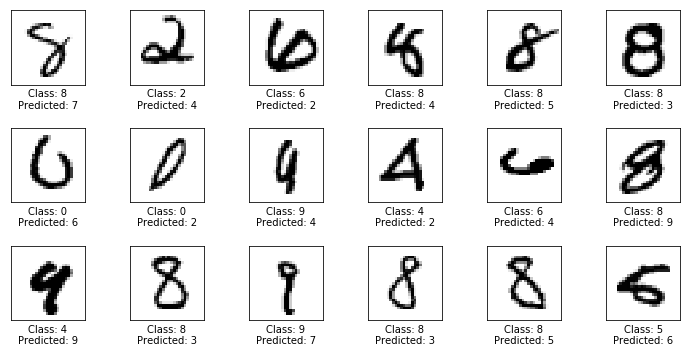

In [16]:
view_errors(shuffle=True)

You can see that the model is making some strange errors. Adding more layers may help.

---
## Deep Netural Networks<a id='deep'></a>

We can reuse code from the previous example to define a convenient function for constructing a layer of a neural network.

In [17]:
def full_connect(input,
                 channels_in,
                 channels_out,
                 act_fn=None):
    
    # A fully connected layer with flexible parameters
    
    x = tf.reshape(input,shape=[-1,channels_in]) # Make sure input is flattened
    w = tf.Variable(tf.truncated_normal([channels_in,channels_out],stddev=0.1))
    b = tf.Variable(tf.ones(channels_out)/10)
    logits = tf.matmul(x,w) + b
    
    if act_fn:
        act = act_fn(logits) # Calculate activations if defined
        return act
    else:
        return logits

This function is essentially the same as the example before except it has been modified to accept and output an arbitrary number of channels.

### Constructing Multiple Layers<a id='constructing'></a>

Now we can stack layers and modify the number of neurons quite easily. We can even define different activation functions using `act_fn`. We will use ReLUs for this network.

In [18]:
tf.reset_default_graph() # Reset structure

x = tf.placeholder(tf.float32,[None,28,28,1]) # Images
y_ = tf.placeholder(tf.float32,[None,10]) # Labels

nfirst = 200 # Num neurons in first layer,
nsecond = 100 # in second,
nthird = 64 # and so on...
nfourth = 30

y1 = full_connect(x,28*28*1,nfirst,tf.nn.relu)
y2 = full_connect(y1,nfirst,nsecond,tf.nn.relu)
y3 = full_connect(y2,nsecond,nthird,tf.nn.relu)
y4 = full_connect(y3,nthird,nfourth,tf.nn.relu)
logits = full_connect(y4,nfourth,10) # Output to 10 classes

y = tf.nn.softmax(logits) # Softmax classification

# Loss function
xent = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=logits)
xent = tf.reduce_mean(xent)*100 # Total cross entropy

train_step = tf.train.AdamOptimizer(0.01).minimize(xent)

# Calculating accuracy
is_correct = tf.equal(tf.arg_max(y_,1),tf.arg_max(y,1))
accuracy = tf.reduce_mean(tf.cast(is_correct,tf.float32))

def train_accuracy():
    return sess.run(accuracy,feed_dict={x:mnist.train.images,y_:mnist.train.labels})
    
def test_accuracy():
    return sess.run(accuracy,feed_dict={x:mnist.test.images,y_:mnist.test.labels})

sess = tf.InteractiveSession() # Open
tf.global_variables_initializer().run() # Initialize

# Training parameters
iterations = 1200
batch_size = 100
notify_every = 300

for i in range(1,iterations + 1):
        batch_x, batch_y = mnist.train.next_batch(batch_size) # Get batch
        sess.run(train_step,feed_dict={x:batch_x,y_:batch_y}) # Train on batch
        
        if i % notify_every==0:
            print('{}\tTrain\t{}'.format(i,train_accuracy()))
            print('\tTest\t{}'.format(test_accuracy()))
        if i % iterations==0:
            print('Done!\tTrain\t{}'.format(train_accuracy()))
            print('\tTest\t{}'.format(test_accuracy()))

300	Train	0.9496344923973083
	Test	0.9467000961303711
600	Train	0.956884503364563
	Test	0.9515001177787781
900	Train	0.9685178995132446
	Test	0.9626001119613647
1200	Train	0.9700678586959839
	Test	0.9606001973152161
Done!	Train	0.9700678586959839
	Test	0.9606000781059265


We gained about 5% accuracy by going deep! Let's see some of the errors.

### The Errors<a id='errors2'></a>

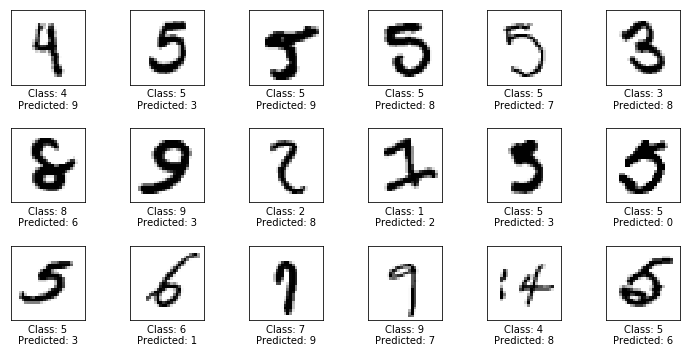

In [19]:
view_errors(shuffle=True)

Some of the errors are understandable, but others are still off. We will see later that a convolutional neural net is better for this dataset.

---
## Tensorboard<a id='tensorboard'></a>

Neural networks are an incredible tool, but they can be somewhat of a blackbox. Thankfully, Tensorflow includes some useful tools to help demystify some of the inner workings of neural nets.

Tensorboard is a suite of visualization tools that come pre-packaged with Tensorflow. With Tensorboard, you can visually explore your Tensorflow graph, view plots of variables of interest, and more.

### Graph Visualizer<a id='graph'></a>

Tensorflow graphs can be organized by a hierarchical naming structure. After adding names to interesting objects, you create a Tensorboard log which you can then view in an ordinary browser.

We will prepare the same code from the previous example in order to visualize the graph structure in Tensorboard. We simply add `name` parameters to interesting values then create a `FileWriter` to write the log.

In [20]:
tf.reset_default_graph()

def full_connect(input,
                 channels_in,
                 channels_out,
                 act_fn=None,
                 name='fc_layer'): # Name layer
    
    with tf.name_scope(name): # Group everything under layer name
        x = tf.reshape(input,shape=[-1,channels_in])
        w = tf.Variable(tf.truncated_normal([channels_in,channels_out],stddev=0.1),\
                        name='weights') # Name weights
        b = tf.Variable(tf.ones(channels_out)/10,name='biases') # Name biases
        logits = tf.matmul(x,w) + b
        
        if act_fn:
            act = act_fn(logits)
            return act
        else:
            return logits

with tf.name_scope('data'): # Group under 'data'
    x = tf.placeholder(tf.float32,[None,28,28,1])
    y_ = tf.placeholder(tf.float32,[None,10])

nfirst = 200
nsecond = 100
nthird = 64
nfourth = 30

y1 = full_connect(x,28*28*1,nfirst,tf.nn.relu,name='fc_layer1') # Name layers
y2 = full_connect(y1,nfirst,nsecond,tf.nn.relu,name='fc_layer2')
y3 = full_connect(y2,nsecond,nthird,tf.nn.relu,name='fc_layer3')
y4 = full_connect(y3,nthird,nfourth,tf.nn.relu,name='fc_layer4')
logits = full_connect(y4,nfourth,10,name='fc_layer5')

y = tf.nn.softmax(logits,name='softmax')

with tf.name_scope('loss'): # Name loss
    xent = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=logits)
    xent = tf.reduce_mean(xent,name='x_entropy')*100 # Name cross entropy

with tf.name_scope('train'): # Name train
    train_step = tf.train.AdamOptimizer(0.01).minimize(xent)

with tf.name_scope('accuracy'): # Name accuracy
    is_correct = tf.equal(tf.arg_max(y_,1),tf.arg_max(y,1))
    accuracy = tf.reduce_mean(tf.cast(is_correct,tf.float32))

def train_accuracy():
    return sess.run(accuracy,feed_dict={x:mnist.train.images,y_:mnist.train.labels})
    
def test_accuracy():
    return sess.run(accuracy,feed_dict={x:mnist.test.images,y_:mnist.test.labels})

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# Create a filewriter and specify a log directory
writer = tf.summary.FileWriter('./Tensorboard/1')
writer.add_graph(sess.graph) # Add graph to logs

iterations = 1200
batch_size = 100
notify_every = 300

for i in range(1,iterations + 1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        sess.run(train_step,feed_dict={x:batch_x,y_:batch_y})
        
        if i % notify_every==0:
            print('{}\tTrain\t{}'.format(i,train_accuracy()))
            print('\tTest\t{}'.format(test_accuracy()))
        if i % iterations==0:
            print('Done!\tTrain\t{}'.format(train_accuracy()))
            print('\tTest\t{}'.format(test_accuracy()))
            
writer.close() # Close filewriter

300	Train	0.9441666603088379
	Test	0.9401000142097473
600	Train	0.9559166431427002
	Test	0.9517999887466431
900	Train	0.9610000252723694
	Test	0.9585999846458435
1200	Train	0.974133312702179
	Test	0.9677000045776367
Done!	Train	0.974133312702179
	Test	0.9677000045776367


There should now be a new file in the specified directory. Type `tensorboard --logdir Tensorboard` in a terminal, then copy the link and open it in a browser. There you can interact with the graph and see how everything is connected.

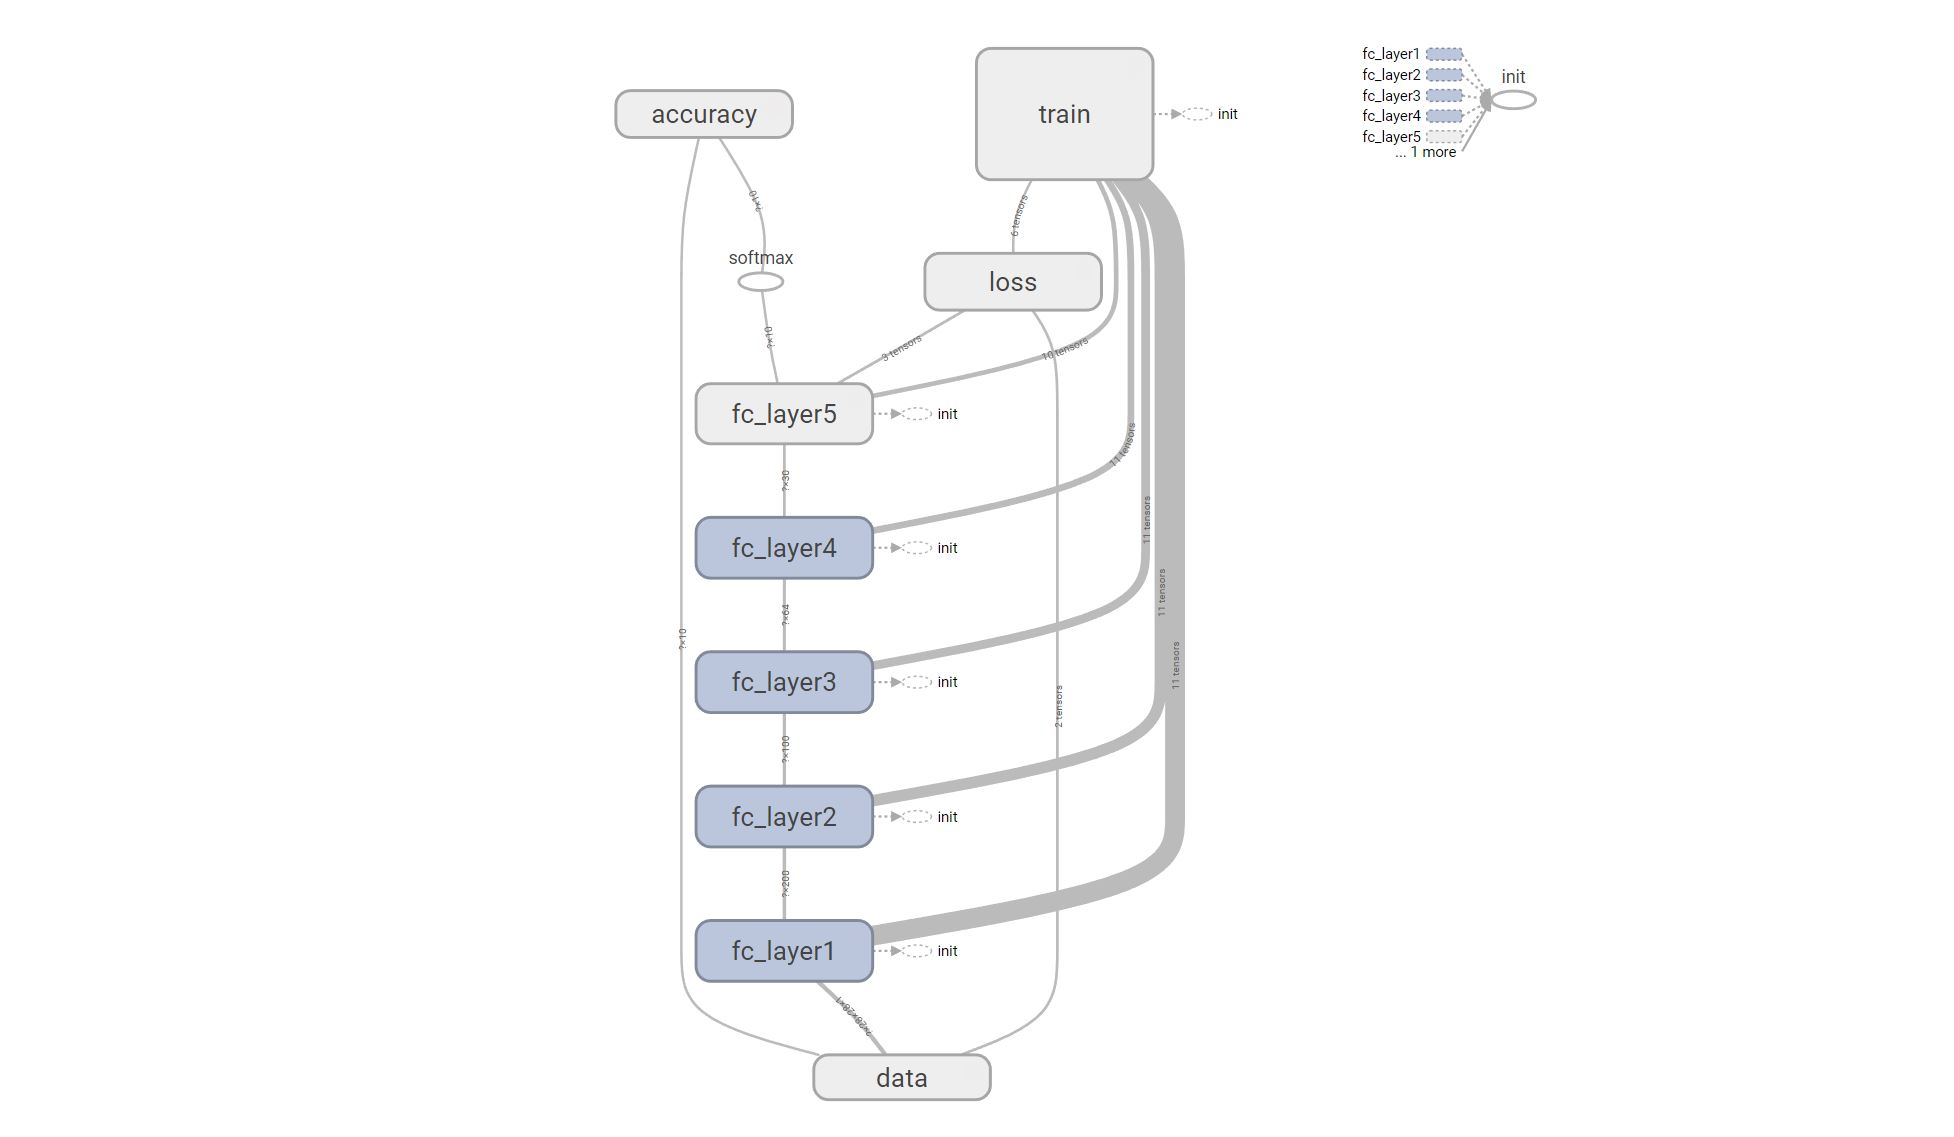

In [21]:
Image('images/graph.jpg')

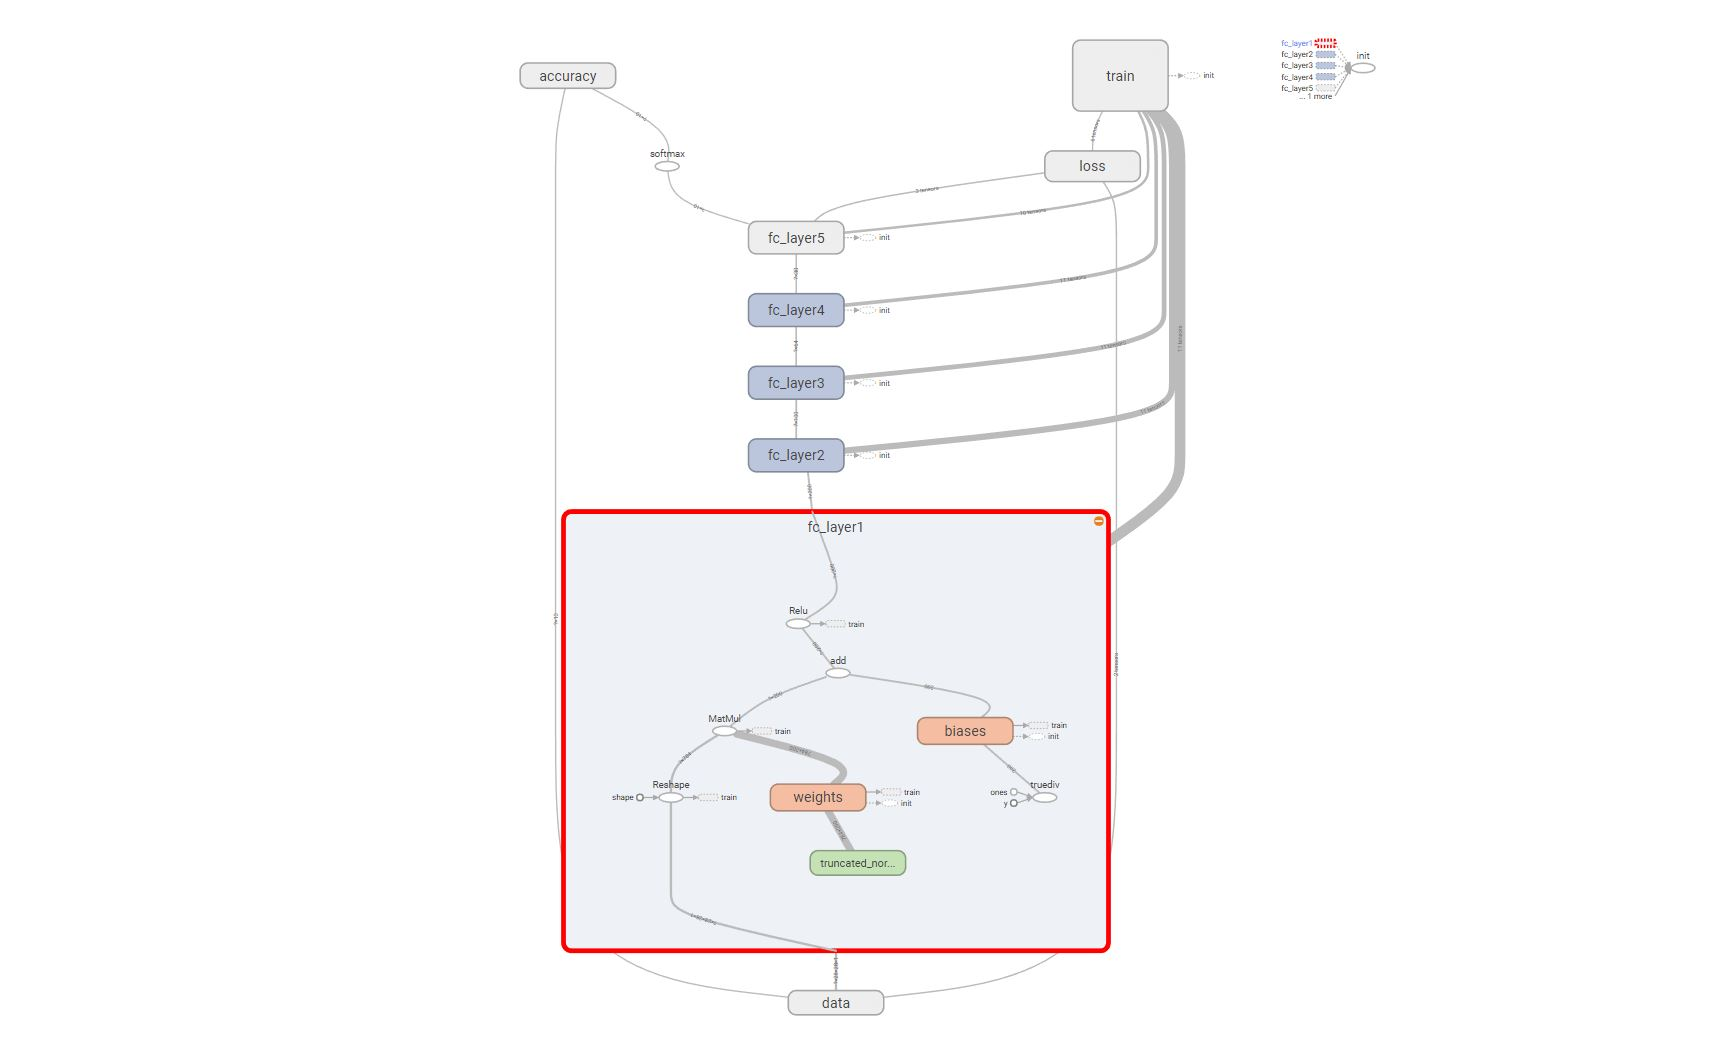

In [22]:
Image('images/graph_expanded.jpg')

### Summaries<a id='summaries'></a>

By adding summaries, we can view plots of interesting values in our model. This code is the same as the previous example only with summaries added.

In [23]:
tf.reset_default_graph()

def full_connect(input,
                 channels_in,
                 channels_out,
                 act_fn=None,
                 name='fc_layer'):
    
    with tf.name_scope(name):
        x = tf.reshape(input,shape=[-1,channels_in])
        w = tf.Variable(tf.truncated_normal([channels_in,channels_out],stddev=0.1),\
                        name='weights')
        b = tf.Variable(tf.ones(channels_out)/10,name='biases')
        tf.summary.histogram('weights',w) # Add weights summary as histogram
        tf.summary.histogram('biases',b) # Add biases summary as histogram
        logits = tf.matmul(x,w) + b
        
        if act_fn:
            act = act_fn(logits)
            return act
        else:
            return logits

with tf.name_scope('data'):
    x = tf.placeholder(tf.float32,[None,28,28,1])
    y_ = tf.placeholder(tf.float32,[None,10])

nfirst = 200
nsecond = 100
nthird = 64
nfourth = 30

y1 = full_connect(x,28*28*1,nfirst,tf.nn.relu,name='fc_layer1')
y2 = full_connect(y1,nfirst,nsecond,tf.nn.relu,name='fc_layer2')
y3 = full_connect(y2,nsecond,nthird,tf.nn.relu,name='fc_layer3')
y4 = full_connect(y3,nthird,nfourth,tf.nn.relu,name='fc_layer4')
logits = full_connect(y4,nfourth,10,name='fc_layer5')

y = tf.nn.softmax(logits,name='softmax')

with tf.name_scope('loss'):
    xent = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=logits)
    xent = tf.reduce_mean(xent,name='x_entropy')*100
    tf.summary.scalar('x_entropy',xent) # Add cross entropy summary as scalar

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(0.01).minimize(xent)

with tf.name_scope('accuracy'):
    is_correct = tf.equal(tf.arg_max(y_,1),tf.arg_max(y,1))
    accuracy = tf.reduce_mean(tf.cast(is_correct,tf.float32))

def train_accuracy():
    return sess.run(accuracy,feed_dict={x:mnist.train.images,y_:mnist.train.labels})
    
def test_accuracy():
    return sess.run(accuracy,feed_dict={x:mnist.test.images,y_:mnist.test.labels})

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# Specify a new directory for this run
writer = tf.summary.FileWriter('./Tensorboard/2')
writer.add_graph(sess.graph)

iterations = 1200
batch_size = 100
notify_every = 300
log_every = 50 # Log the summaries every few iterations

for i in range(1,iterations + 1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        sess.run(train_step,feed_dict={x:batch_x,y_:batch_y})
        
        if i % notify_every==0:
            print('{}\tTrain\t{}'.format(i,train_accuracy()))
            print('\tTest\t{}'.format(test_accuracy()))
            
        if i % log_every==0:
            merged_summary = sess.run(tf.summary.merge_all(),\
                                      feed_dict={x:mnist.train.images,y_:mnist.train.labels})
            writer.add_summary(merged_summary,i) # Merge and add all summaries at once
            
        if i % iterations==0:
            print('Done!\tTrain\t{}'.format(train_accuracy()))
            print('\tTest\t{}'.format(test_accuracy()))
            
writer.close()

300	Train	0.9486666917800903
	Test	0.9440000057220459
600	Train	0.9536166787147522
	Test	0.9527000188827515
900	Train	0.9674833416938782
	Test	0.9605000019073486
1200	Train	0.9696000218391418
	Test	0.9602000117301941
Done!	Train	0.9696000218391418
	Test	0.9602000117301941


Below are a few summaries from the Tensorboard output.

##### Cross Entropy During Training

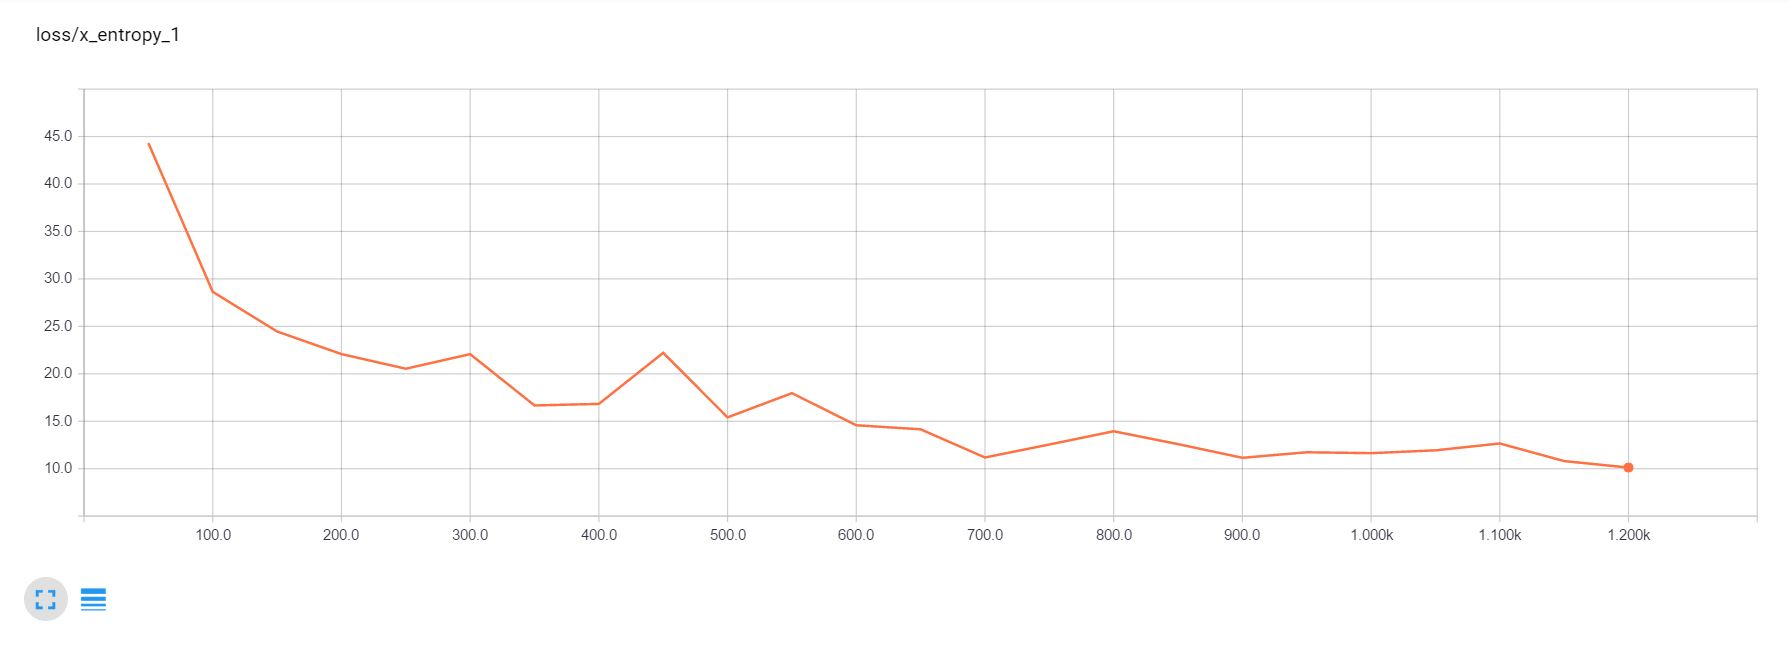

In [24]:
Image('images/loss.jpg')

##### Distribution of Biases in 4th Layer

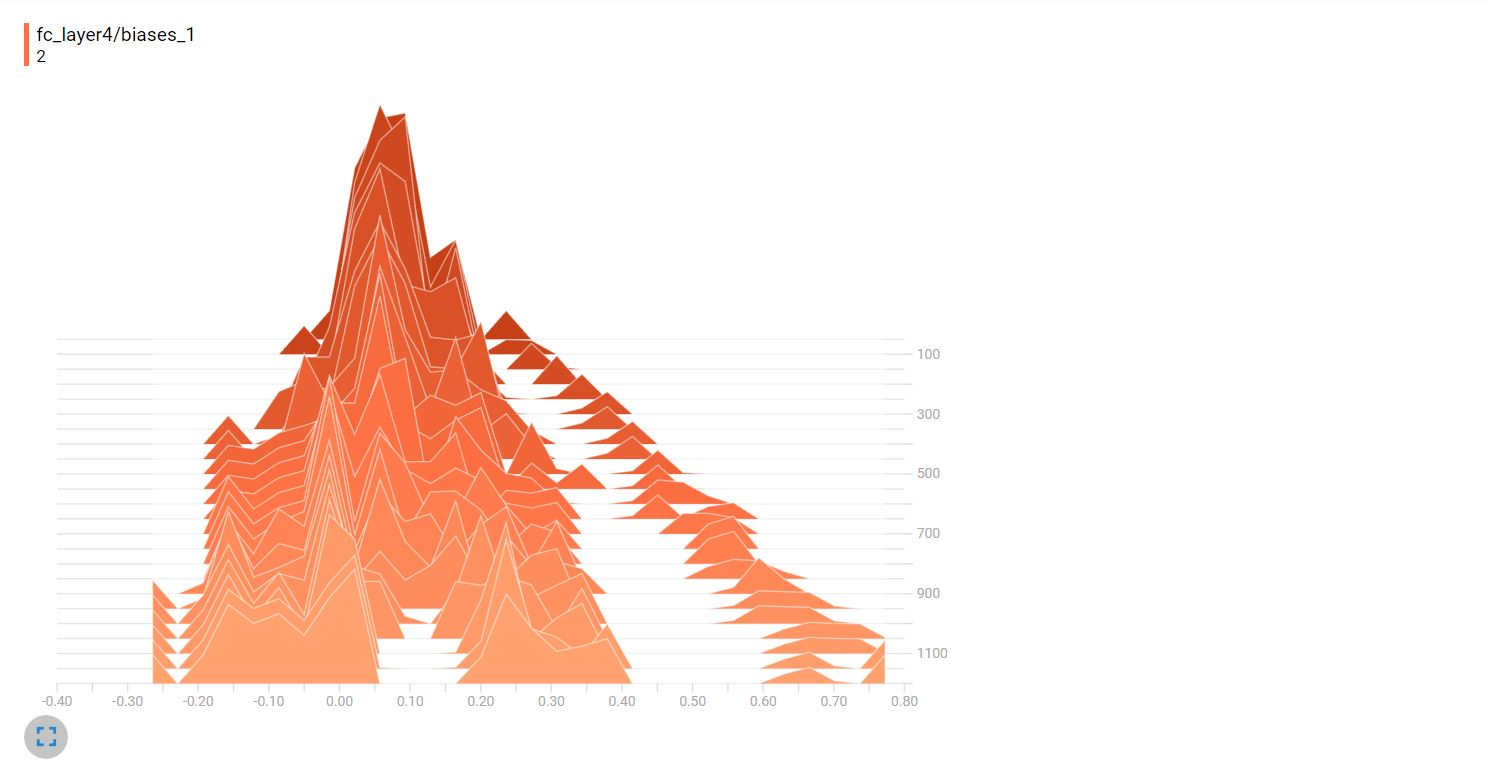

In [25]:
Image('images/biases.jpg')

##### Distribution of Weights in 5th Layer

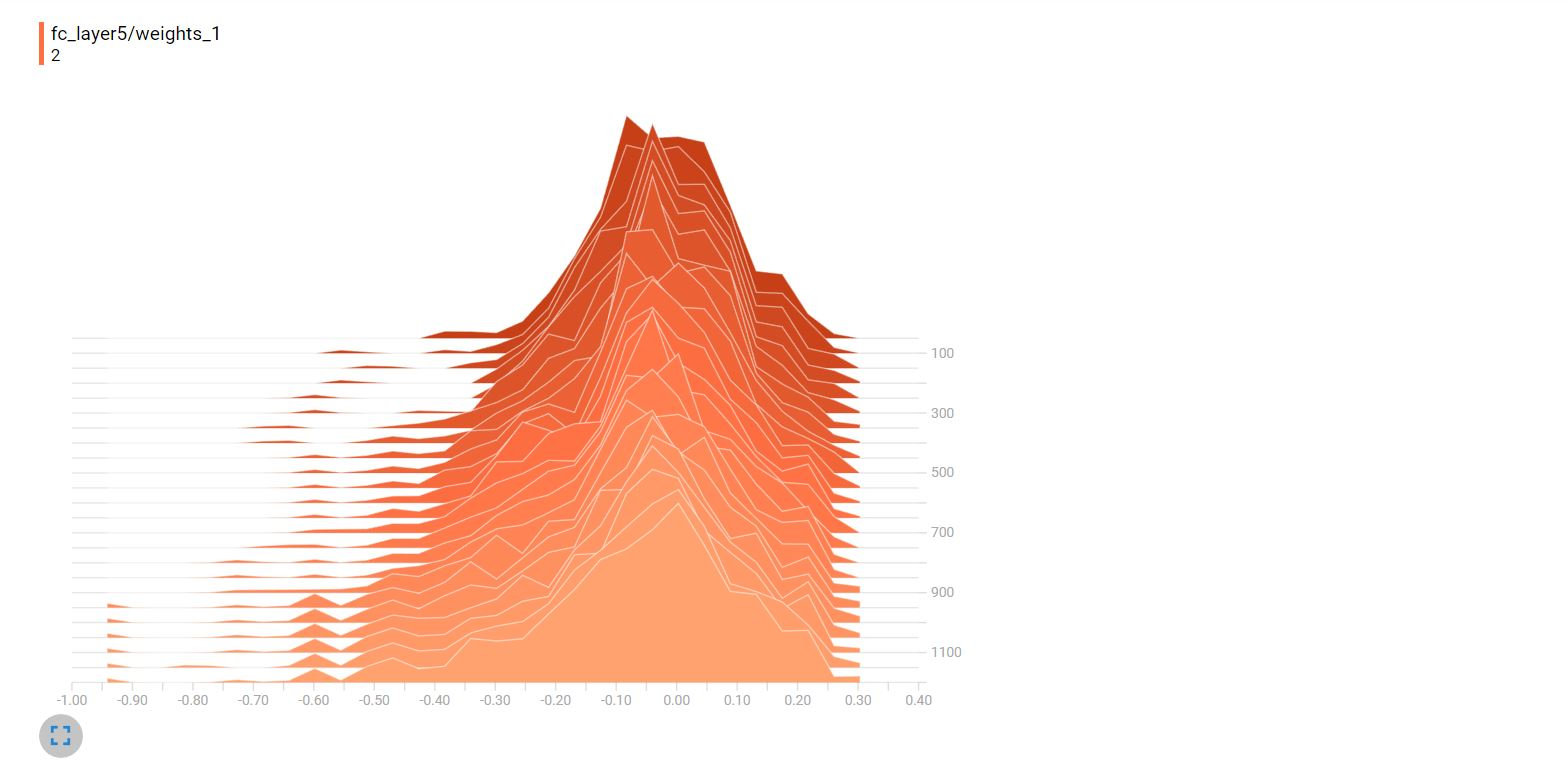

In [26]:
Image('images/weights.jpg')

---
## Convolutional Neural Networks<a id='convolutional'></a>

If we want to do really well on MNIST we should implement a convolutional network. Convolutional networks tend to preserve shape information unlike the previous network where our images were flattened.

Below is a function to construct a convolutional layer.

In [27]:
def convolutional(input,
                  channels_in,
                  channels_out, # Depth
                  filter_dim,   # Filter width and height
                  stride,       # Num pixels to slide over
                  act_fn=None,
                  name='convolutional'):
    
    # A convolutional layer with flexible parameters and Tensorboard built-in.
    
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal(\
                                [filter_dim,filter_dim,channels_in,channels_out],\
                                stddev=0.1),name='weights')
        b = tf.Variable(tf.constant(0.1,tf.float32,[channels_out]),name='biases')
        
        tf.summary.histogram('weights',w)
        tf.summary.histogram('biases',b)
        
        logits = tf.nn.conv2d(input,w,[1,stride,stride,1],'SAME') + b
        
        if act_fn:
            act = act_fn(logits)
            return act
        else:
            return logits

You can see how `tf.nn.conv2d` does most of the heavy lifting for us. Now let's substitute a few convolutional layers and see how our network performs.

In [28]:
tf.reset_default_graph() # Reset graph

with tf.name_scope('data'):
    x = tf.placeholder(tf.float32,[None,28,28,1]) # Images
    y_ = tf.placeholder(tf.float32,[None,10]) # Labels

# 1st convolution parameters
channels_a = 6
filter_a = 6
stride_a = 1

# 2nd convolution parameters
channels_b = 12
filter_b = 5
stride_b = 2

# 3rd convolution parameters
channels_c = 24
filter_c = 4
stride_c = 2

neurons_d = 200 # Neurons in 4th layer

# Construct convolutional layers
y1 = convolutional(x,1,channels_a,filter_a,stride_a,\
                   act_fn=tf.nn.relu,name='conv_1')
y2 = convolutional(y1,channels_a,channels_b,filter_b,stride_b,\
                   act_fn=tf.nn.relu,name='conv_2')
y3 = convolutional(y2,channels_b,channels_c,filter_c,stride_c,\
                   act_fn=tf.nn.relu,name='conv_3')

side_length = 28/(stride_a*stride_b*stride_c)
neurons_c = int((side_length**2)*channels_c) # Num neurons after 3rd convolution

y4 = full_connect(y3,neurons_c,neurons_d,\
                  act_fn=tf.nn.relu,name='fc_4')

logits = full_connect(y4,neurons_d,10,name='fc_5') # Output to 10 channels

y = tf.nn.softmax(logits,name='softmax') # Softmax classification

with tf.name_scope('loss'):
    xent = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=logits)
    xent = tf.reduce_mean(xent,name='x_entropy')*100 # Total cross entropy
    tf.summary.scalar('x_entropy',xent)

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(0.003).minimize(xent)

# Calculating accuracy
with tf.name_scope('accuracy'):
    is_correct = tf.equal(tf.arg_max(y_,1),tf.arg_max(y,1))
    accuracy = tf.reduce_mean(tf.cast(is_correct,tf.float32))

def train_accuracy():
    return sess.run(accuracy,feed_dict={x:mnist.train.images,y_:mnist.train.labels})
    
def test_accuracy():
    return sess.run(accuracy,feed_dict={x:mnist.test.images,y_:mnist.test.labels})

sess = tf.InteractiveSession() # Open
tf.global_variables_initializer().run() # Initialize

# Specify a new directory for this run
writer = tf.summary.FileWriter('./Tensorboard/3')
writer.add_graph(sess.graph) # Add graph

# Training parameters
iterations = 1500
batch_size = 100
notify_every = 300
log_every = 50

for i in range(1,iterations + 1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        sess.run(train_step,feed_dict={x:batch_x,y_:batch_y})
        
        if i % notify_every==0:
            print('{}\tTrain\t{}'.format(i,train_accuracy()))
            print('\tTest\t{}'.format(test_accuracy()))
            
        if i % log_every==0:
            merged_summary = sess.run(tf.summary.merge_all(),\
                              feed_dict={x:mnist.train.images,y_:mnist.train.labels})
            writer.add_summary(merged_summary,i) # Add all summaries
            
        if i % iterations==0:
            print('Done!\tTrain\t{}'.format(train_accuracy()))
            print('\tTest\t{}'.format(test_accuracy()))
            
writer.close() # Close writer

300	Train	0.9747999906539917
	Test	0.9740999937057495
600	Train	0.9807166457176208
	Test	0.9807000160217285
900	Train	0.9879999756813049
	Test	0.9857000112533569
1200	Train	0.9894499778747559
	Test	0.9865000247955322
1500	Train	0.9888166785240173
	Test	0.9843999743461609
Done!	Train	0.9888166785240173
	Test	0.9843999743461609


We've managed to grab another 2% percent or so using convolutional layers! Let's try a couple more tricks to see if we can push our accuracy past 99%. We will implement a decaying learning rate, and regularization in the form of dropout.

### Decaying Learning Rate<a id='learning'></a>

A decaying learning rate will help the optimizer close in on a local minima more quickly, and also enable finer adjustments later on. Below we define a function for our decay.

In [29]:
def lr_decay(i,max_lr,min_lr,decay):
    
    return min_lr + (max_lr-min_lr)*math.exp(-i/decay)

Let's specify our parameters and see how this function changes over time.

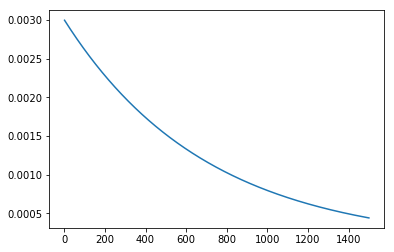

In [30]:
max_lr = 0.003 # Maximum learning rate
min_lr = 0.0001 # Minimum learning rate
decay = 700 # Decay rate

x = np.arange(1,1500+1) # Number of iterations
f = np.vectorize(lr_decay)
plt.plot(x, f(x,max_lr,min_lr,decay))
plt.show()

### Dropout Regularlization<a id='dropout'></a>

Dropout works by shutting off neurons at random while the model trains. This combats overfitting by reducing dependencies that neurons might have with one another, requiring the neuron to "think on its own". Tensorflow includes `tf.nn.dropout` which makes implementing dropout easy. We will apply dropout to the 4th layer, and keep neurons with probability 0.75. During each training step, any neuron in this layer is off with probability 0.25.

The model below includes both a decaying learning rate and dropout. Let's see if the results improve.

In [34]:
tf.reset_default_graph() # Reset graph

with tf.name_scope('data'):
    x = tf.placeholder(tf.float32,[None,28,28,1]) # Images
    y_ = tf.placeholder(tf.float32,[None,10]) # Labels

# 1st convolution parameters
channels_a = 6
filter_a = 6
stride_a = 1

# 2nd convolution parameters
channels_b = 12
filter_b = 5
stride_b = 2

# 3rd convolution parameters
channels_c = 24
filter_c = 4
stride_c = 2

neurons_d = 200 # Neurons in 4th layer

# Construct convolutional layers
y1 = convolutional(x,1,channels_a,filter_a,stride_a,\
                   act_fn=tf.nn.relu,name='conv_1')
y2 = convolutional(y1,channels_a,channels_b,filter_b,stride_b,\
                   act_fn=tf.nn.relu,name='conv_2')
y3 = convolutional(y2,channels_b,channels_c,filter_c,stride_c,\
                   act_fn=tf.nn.relu,name='conv_3')

side_length = 28/(stride_a*stride_b*stride_c)
neurons_c = int((side_length**2)*channels_c) # Num neurons after 3rd convolution

y4 = full_connect(y3,neurons_c,neurons_d,\
                  act_fn=tf.nn.relu,name='fc_4')

pkeep = tf.placeholder(tf.float32)
y4d = tf.nn.dropout(y4,pkeep,name='dropout') # Dropout

logits = full_connect(y4d,neurons_d,10,name='fc_5') # Output to 10 channels

y = tf.nn.softmax(logits,name='softmax') # Softmax classification

with tf.name_scope('loss'):
    xent = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=logits)
    xent = tf.reduce_mean(xent,name='x_entropy')*100 # Total cross entropy
    tf.summary.scalar('x_entropy',xent)

with tf.name_scope('train'):
    lr = tf.placeholder(tf.float32) # Input decaying learning rate
    train_step = tf.train.AdamOptimizer(lr).minimize(xent)

# Calculating accuracy
with tf.name_scope('accuracy'):
    is_correct = tf.equal(tf.arg_max(y_,1),tf.arg_max(y,1))
    accuracy = tf.reduce_mean(tf.cast(is_correct,tf.float32))

def train_accuracy(): # Include all neurons when determining accuracy
    return sess.run(accuracy,\
                    feed_dict={x:mnist.train.images,y_:mnist.train.labels,pkeep:1.0})
    
def test_accuracy(): # Include all neurons when determining accuracy
    return sess.run(accuracy,\
                    feed_dict={x:mnist.test.images,y_:mnist.test.labels,pkeep:1.0})

sess = tf.InteractiveSession() # Open
tf.global_variables_initializer().run() # Initialize

# Specify a new directory for this run
writer = tf.summary.FileWriter('./Tensorboard/4')
writer.add_graph(sess.graph) # Add graph

# Training parameters
iterations = 1500
batch_size = 100
notify_every = 300
log_every = 50

keep_prob = 0.75 # Dropout pkeep

# Learning rate parameters
max_lr = 0.003
min_lr = 0.0001
decay = 700

for i in range(1,iterations + 1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        
        # Calculate the learning rate for this time step
        learning_rate = lr_decay(i,max_lr,min_lr,decay)
        
        # Train step with learning rate and dropout input
        sess.run(train_step,\
                 feed_dict={x:batch_x,y_:batch_y,lr:learning_rate,pkeep:keep_prob})
        
        if i % notify_every==0:
            print('{}\tTrain\t{}'.format(i,train_accuracy()))
            print('\tTest\t{}'.format(test_accuracy()))
            
        if i % log_every==0:
            merged_summary = sess.run(tf.summary.merge_all(),\
                              feed_dict={x:mnist.train.images,y_:mnist.train.labels,pkeep:1.0})
            writer.add_summary(merged_summary,i) # Add all summaries
            
        if i % iterations==0:
            print('Done!\tTrain\t{}'.format(train_accuracy()))
            print('\tTest\t{}'.format(test_accuracy()))
            
writer.close() # Close writer

300	Train	0.975433349609375
	Test	0.9782000184059143
600	Train	0.9838166832923889
	Test	0.9836999773979187
900	Train	0.9882833361625671
	Test	0.9869999885559082
1200	Train	0.9914166927337646
	Test	0.9886000156402588
1500	Train	0.9931833148002625
	Test	0.9900000095367432
Done!	Train	0.9931833148002625
	Test	0.9900000095367432


And we are at 99%! Let's see some errors and view the logs.

### Errors and Logs<a id='logs'></a>

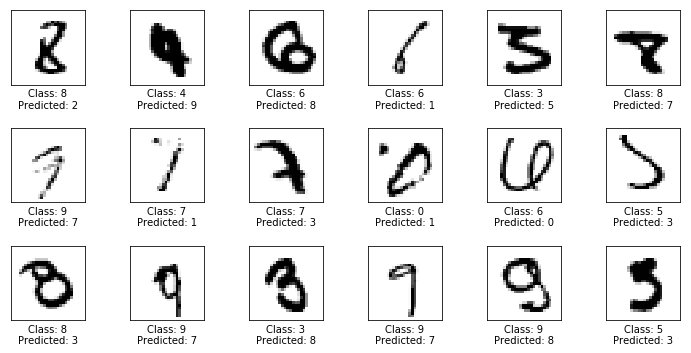

In [35]:
view_errors(shuffle=True,dropout=True)

Quite a few of these errors involve poor handwriting so this is understandable.

#### Graph Structure

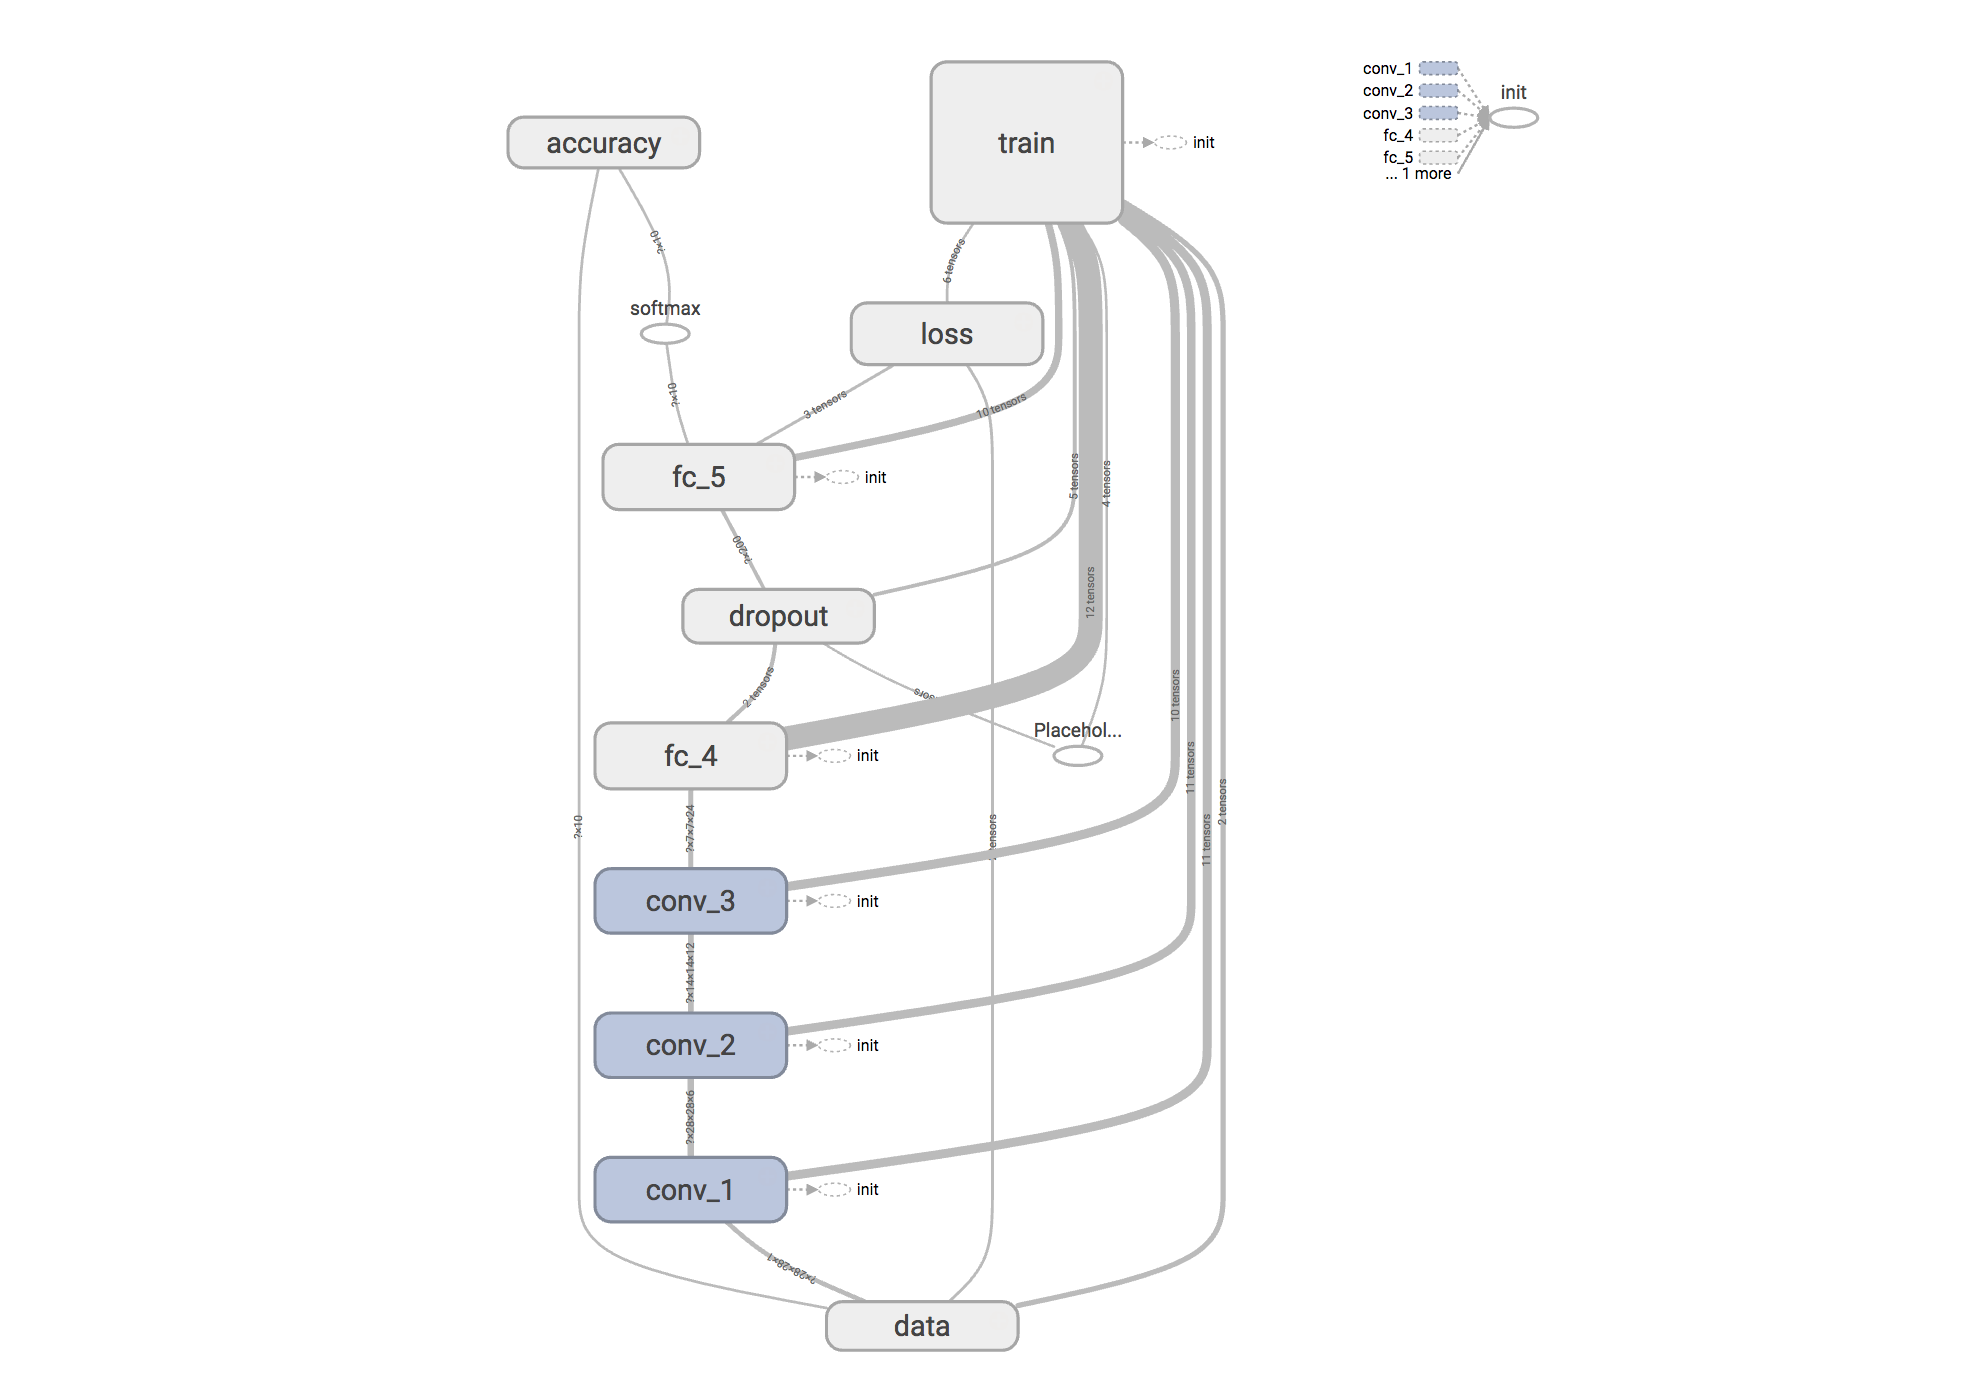

In [36]:
Image('images/graph2.png')

#### Distribution of Weights in 1st Convolutional Layer

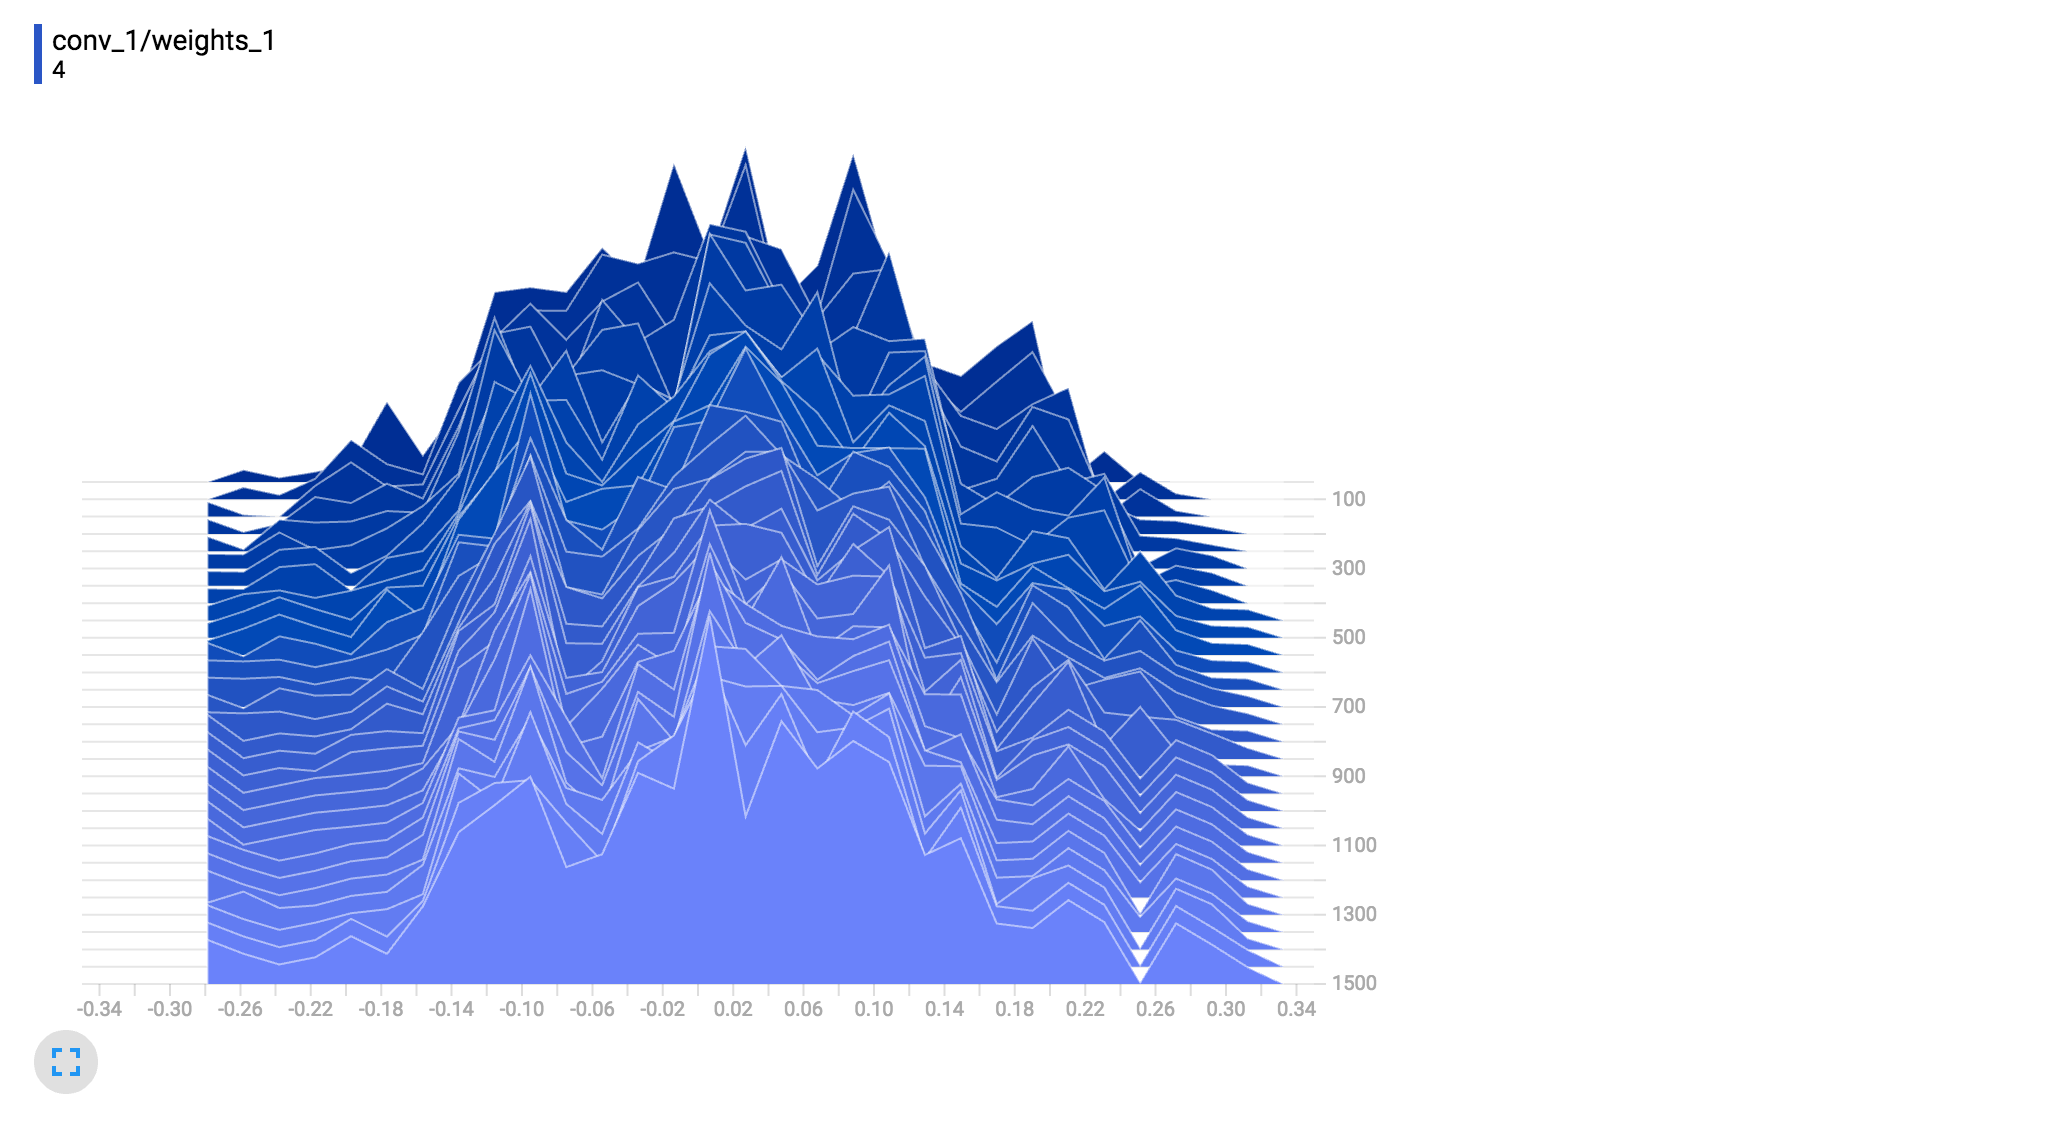

In [37]:
Image('images/weights2.png')

#### Distribution of Biases in 2nd Convolutional Layer

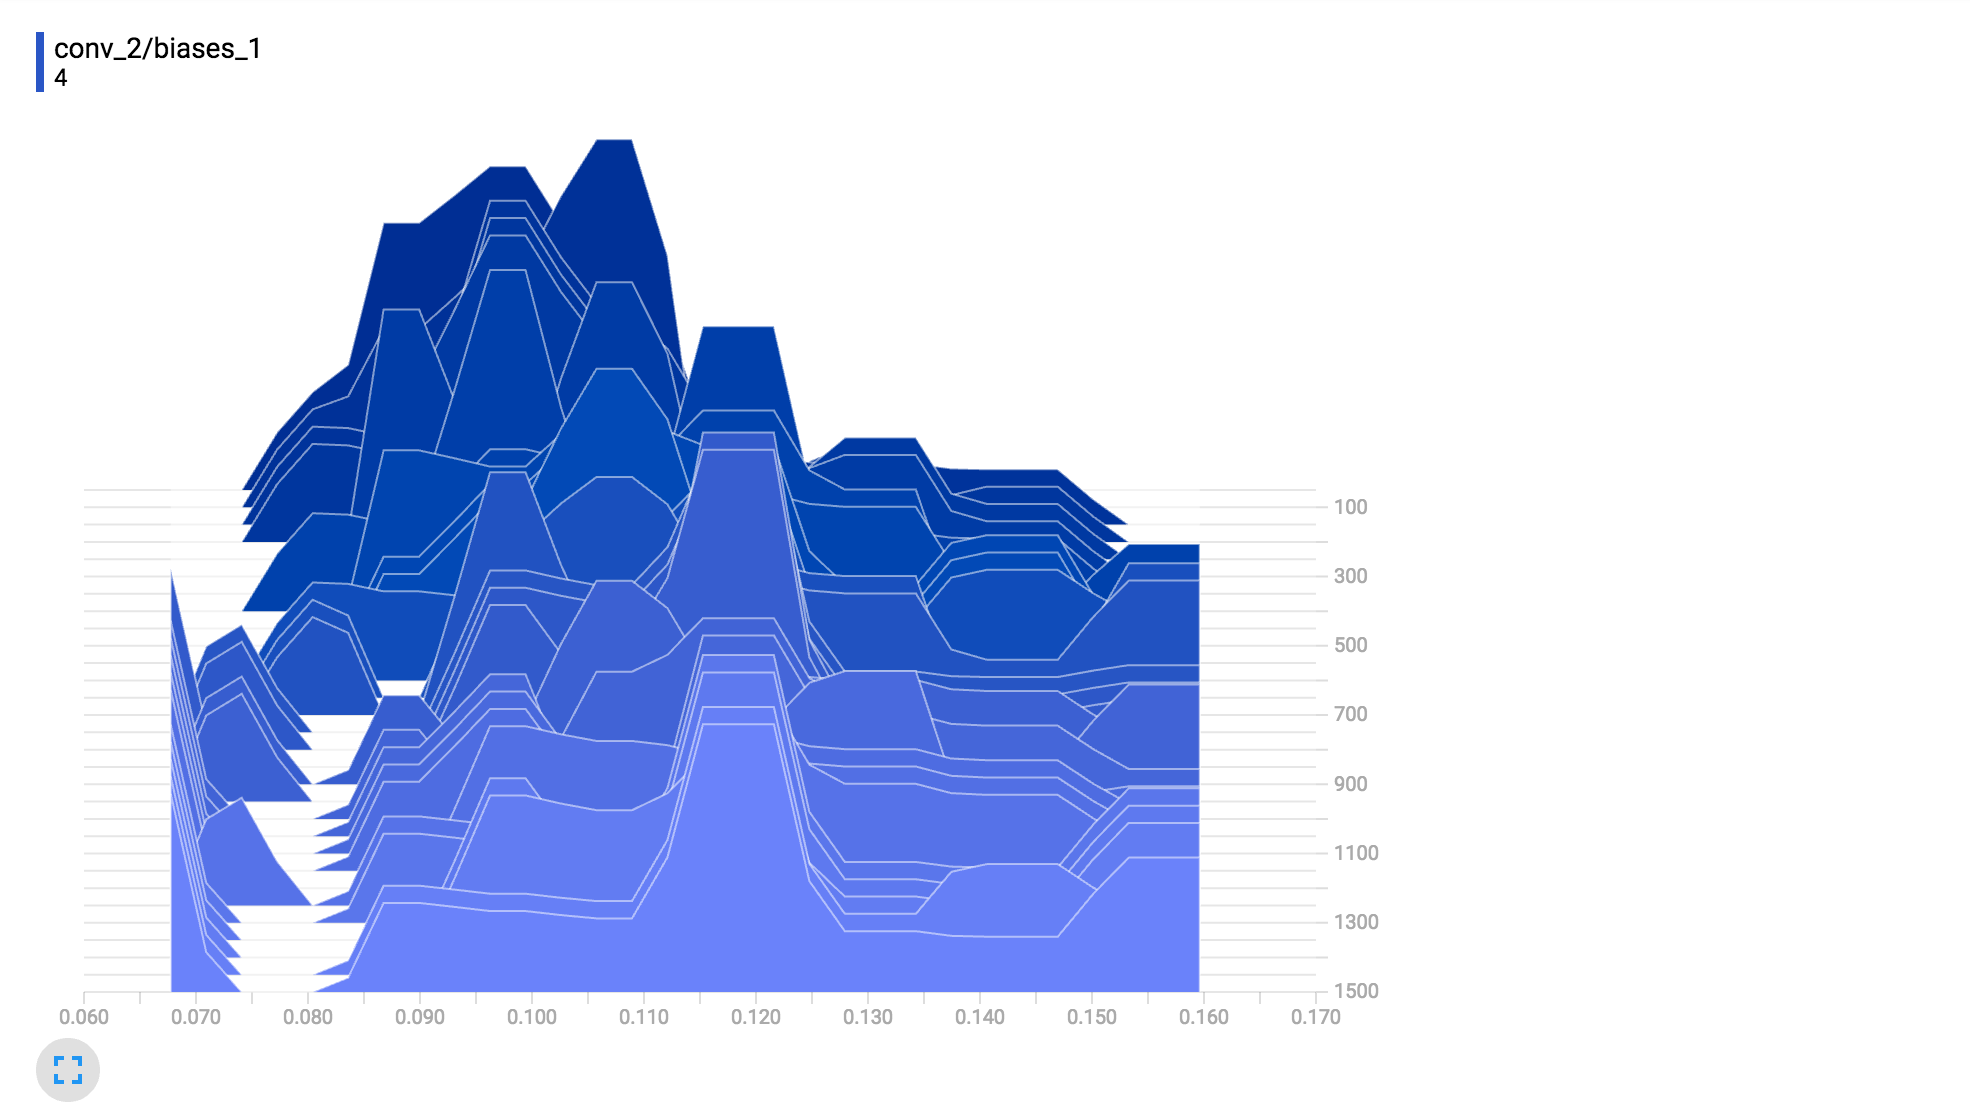

In [38]:
Image('images/biases2.png')